In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

sys.path.append("../")
import vuong_tests

In [2]:
#generate the sample
def gen_data(beta=3):
    nobs = 1000
    x = np.random.uniform(low=-3., high=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + beta * x[:,1] + e
    return y,x,nobs

yn,xn,nobs = gen_data()

In [3]:
def compute_loglike(resid):
    sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
    ll = np.log(stats.norm.pdf(resid,loc=0,scale=sigma))
    return ll

In [4]:
def compute_llr(yn,xn):
    x1n,x2n = xn[:,0:2],xn[:,1:3]
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    ll1 = compute_loglike(model1_fit.resid)

    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    ll2 = compute_loglike(model2_fit.resid)

    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(-2.3528718440611556, 0.07057781250869871)


0
0


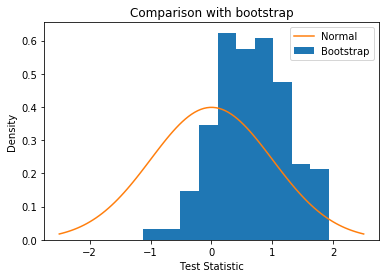

In [5]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare10')
plt.show()

In [6]:
reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))

reg: [1. 0. 0.], boot1: [0.93 0.03 0.04], boot2: [1. 0. 0.], llr:-0.06079474006706278, omega:0.03917897871910166


In [7]:
def compute_score(yn,xn,params):
    
    xn = sm.add_constant(xn)
    resid = yn - np.matmul(xn,params)
    
    k = len(params)
    scale = (resid**2).mean()
    
    tile_resid = np.tile( resid, k)
    tile_resid = np.reshape(tile_resid, (k,xn.shape[0]) ).transpose()
    grad = tile_resid*xn/scale     
    return grad
    
def compute_hess(yn,xn,params):
    pass


def setup_shi(yn,xn):
    x1n,x2n = xn[:,0:2],xn[:,1:3]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    k1 = len(model1_fit.params)
    
    ll1 = compute_loglike(model1_fit.resid)
    grad1 =  compute_score(yn,x1n,model1_fit.params)
    hess1 = model1.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    k2 = len(model1_fit.params)
    
    ll2 = compute_loglike(model2_fit.resid)
    grad2 =  compute_score(yn,x2n,model2_fit.params)
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [8]:
sys.path.append("../")
import vuong_tests

shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

[1. 0. 0.]


In [9]:
#generate the sample
def gen_data(beta=3):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + 1*x[:,2] + 1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs

reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

reg: [0.95 0.03 0.02], boot1: [0.95 0.03 0.02], boot2: [0.95 0.03 0.02], llr:5.21003199719587, omega:0.986703844991874
[0.97 0.02 0.01]


In [10]:
#generate the sample
def gen_data(beta=1):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + beta * x[:,1] + e
    return y,x,nobs

reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

reg: [1. 0. 0.], boot1: [0.94 0.04 0.02], boot2: [0.99 0.01 0.  ], llr:0.18059895023295439, omega:0.039656953926149735
[1. 0. 0.]


In [11]:
#generate the sample
def gen_data(beta=3):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + .1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs

reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

reg: [0. 1. 0.], boot1: [0. 1. 0.], boot2: [0. 1. 0.], llr:43.18914869175195, omega:0.2894475246937323
[0. 1. 0.]


In [12]:
#generate the sample
def gen_data(beta=3):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + .01*x[:,0] + beta * x[:,1] + e
    return y,x,nobs

reg,boot1,boot2, llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr,use_boot2=True)
print("reg: %s, boot1: %s, boot2: %s, llr:%s, omega:%s"%(reg,boot1,boot2,llr, omega))
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

reg: [1. 0. 0.], boot1: [0.9  0.08 0.02], boot2: [1. 0. 0.], llr:0.4411584164367127, omega:0.04352293718089093
[1. 0. 0.]
